# Analysis

After running `compare.py` on various sources (chng, nchs, dsew, hhs, quidel), this analysis notebook pinpoints where/when the difference between api and S3 happened.

### Preprocess:

Since compare.py outputs a series of json objects separated by commas instead of valid json file, this following chunk converts all json of this bad form in current dir to good format.

In [180]:
# # Make output file actually valid json by adding brackets
# import glob
# import pandas as pd

# dotjson_files = glob.glob('*.json')

# for dotjson_file in dotjson_files:
#     # Open the file and read it into a string
#     with open(dotjson_file, 'r') as f:
#         content = f.read()

#     # Add the brackets
#     content = '[' + content[:-2] + ']'

#     # Write the string back to the file
#     with open(dotjson_file, 'w') as f:
#         f.write(content)

Read all json files in current dir to a df.

In [181]:

import glob
import pandas as pd

json_files = glob.glob('*.json')

# Read all the JSON files into a list of DataFrames
dfs = [pd.read_json(file) for file in json_files]

# Concatenate all the DataFrames into one
df = pd.concat(dfs, ignore_index=True)
print(df.columns)


Index(['file_name', 'source', 'signal', 'time_value', 'geo_type',
       'dif_row_count', 's3_row_count', 'api_row_count', 'full_dif', 'skip',
       'reason'],
      dtype='object')


In [182]:
df['time_value'] = df['time_value'].fillna(0).astype(int)

## General Analysis
Around 20-25% of the files have differences.

In [183]:
print('number of s3 csv files processed by compare.py',len(df))
print('number of s3 csv files with differences found',len(df[df['dif_row_count']!=0]))


number of s3 csv files processed by compare.py 464016
number of s3 csv files with differences found 94402


`diff_rate` takes into account how data in a s3 csv could be different from its api equivalent by 1 row or 3000 rows. If the  `diff_rate` of a file is 1, it means all rows are different. if the value is 0, then all rows in a s3 file are the same and there is no difference.

In [184]:
df['diff_rate'] = df['dif_row_count']/(df['api_row_count']+df['s3_row_count'])

Among files with differences, let's look at how often an archive differ csv file is are vastly/slightly different from what's on the api.

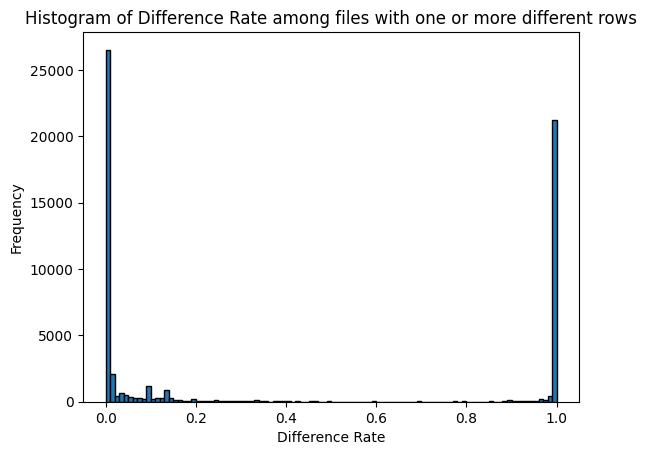

In [185]:
import matplotlib.pyplot as plt
diff = df[df['diff_rate']!=0]
# Create a histogram of the 'diff_rate' column
plt.hist(diff['diff_rate'], bins=100, edgecolor='black')

# Set the labels and title
plt.xlabel('Difference Rate')
plt.ylabel('Frequency')
plt.title('Histogram of Difference Rate among files with one or more different rows')

# Display the plot
plt.show()

This means majority of the files that are different have almost completely different data, while the rest of the files are only slightly different.

## Specific Indicators
#### 1. Quidel
Most quidel s3 files have all rows matching api equivalent.
Signal `county_covid_ag_smoothed_pct_positive` has significant difference (2000 out of around 10,000 files with some row difference from api).
Most of the mismatch happened between 2020 and 2022, with a weird spike in late 2022, then stabilize afterwards. 

In [186]:
quidel = df[df["source"]=="quidel"]
# quidel.head()

In [187]:
print(len(quidel[quidel['dif_row_count']!=0]))
print(len(quidel))
print(len(quidel[quidel['dif_row_count']!=0])/len(quidel))

6892
123512
0.055800246129930696


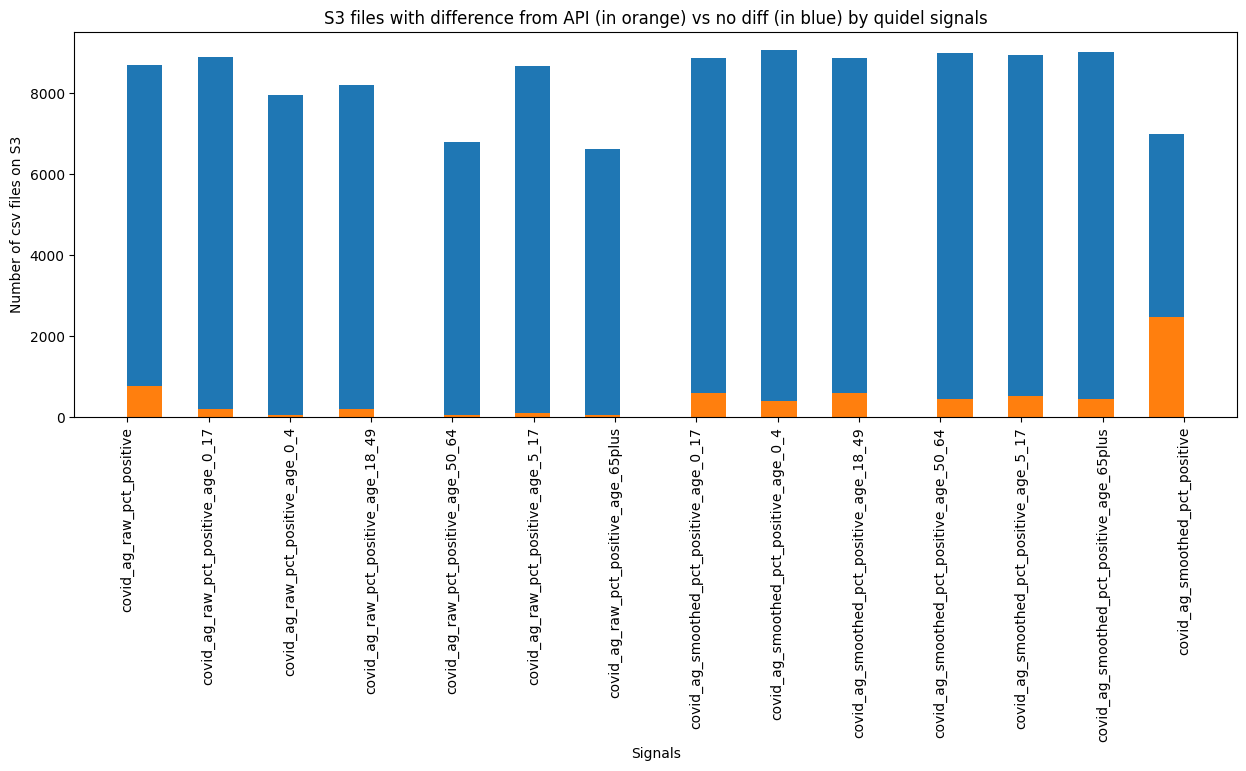

In [188]:
quidel_match = quidel[quidel['dif_row_count']==0]
quidel_diff = quidel[quidel['dif_row_count']!=0]

# Create a histogram of the 'signal' column
plt.figure(figsize=(15, 5))
plt.hist(quidel_match['signal'], bins=30, linestyle=':')
plt.hist(quidel_diff['signal'], bins=30,)

# Set the labels and title
plt.xlabel('Signals')
plt.ylabel('Number of csv files on S3')
plt.title('S3 files with difference from API (in orange) vs no diff (in blue) by quidel signals')
plt.xticks(rotation=90)
# Display the plot
plt.show()

/var/folders/gk/ld02_6n171z4tz6ddznd2crc0000gn/T/ipykernel_8971/2317541109.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quidel_diff['time_value'] = pd.to_datetime(quidel_diff['time_value'], format='%Y%m%d')


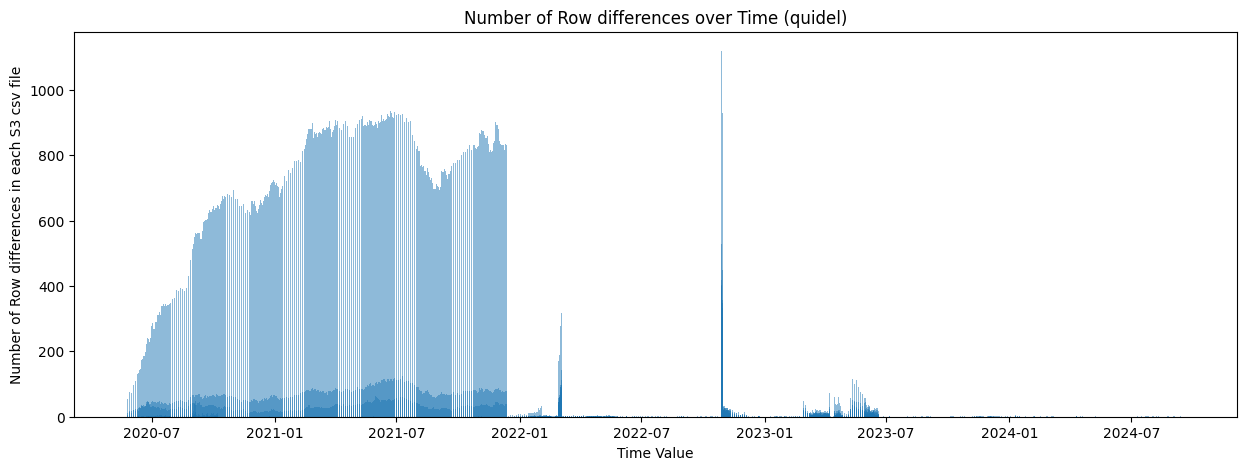

In [189]:


import matplotlib.pyplot as plt
import pandas as pd

# Convert 'time_value' to datetime
quidel_diff['time_value'] = pd.to_datetime(quidel_diff['time_value'], format='%Y%m%d')
#quidel['time_value'] = pd.to_datetime(quidel['time_value'], format='%Y%m%d')

# Create a plot
plt.figure(figsize=(15, 5))
plt.bar(quidel_diff['time_value'], quidel_diff['dif_row_count'], alpha=0.5)
#plt.bar(quidel['time_value'],  quidel['s3_row_count'], color='black', alpha=0.5)

# Set the labels and title
plt.xlabel('Time Value')
plt.ylabel('Number of Row differences in each S3 csv file')
plt.title('Number of Row differences over Time (quidel)')

# Display the plot
plt.show()

#### 2. nchs
Note: All data from csv is different from api.

In [190]:
nchs = df[df["source"]=="nchs-mortality"]
#nchs.head(10)

In [191]:
print(len(nchs[nchs['dif_row_count']!=0]))
print(len(nchs))
print(len(nchs[nchs['dif_row_count']!=0])/len(nchs))

41840
41840
1.0


In [192]:
nchs_diff = nchs[nchs['dif_row_count']!=0]
nchs_diff = nchs_diff[nchs_diff['skip']==False]

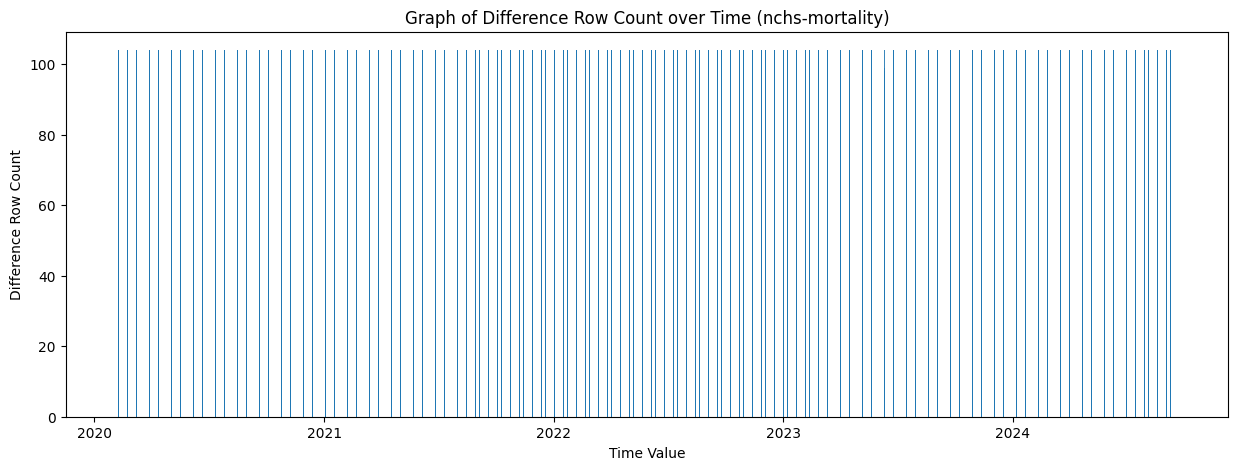

In [193]:
nchs_diff['time_value'] = nchs_diff['time_value'].astype(str) + '0'

# Convert 'time_value' to datetime
nchs_diff['time_value'] = pd.to_datetime(nchs_diff['time_value'], format='%Y%U%w')

# Create a plot
plt.figure(figsize=(15, 5))
plt.bar(nchs_diff['time_value'], nchs_diff['dif_row_count'], alpha=0.5)

# Set the labels and title
plt.xlabel('Time Value')
plt.ylabel('Difference Row Count')
plt.title('Graph of Difference Row Count over Time (nchs-mortality)')

# Display the plot
plt.show()

#### 3. chng

Almost 40% of files have some differences from api.
Two separate periods of mismatch:
- Mid 2020 to late 2021
- mid 2023 when the big contract patch happened.

In [194]:
chng = df[df["source"]=="chng"]
#chng.head(10)

In [195]:
print(len(chng[chng['dif_row_count']!=0]))
print(len(chng))
print(len(chng[chng['dif_row_count']!=0])/len(chng))

19265
51084
0.37712395270534804


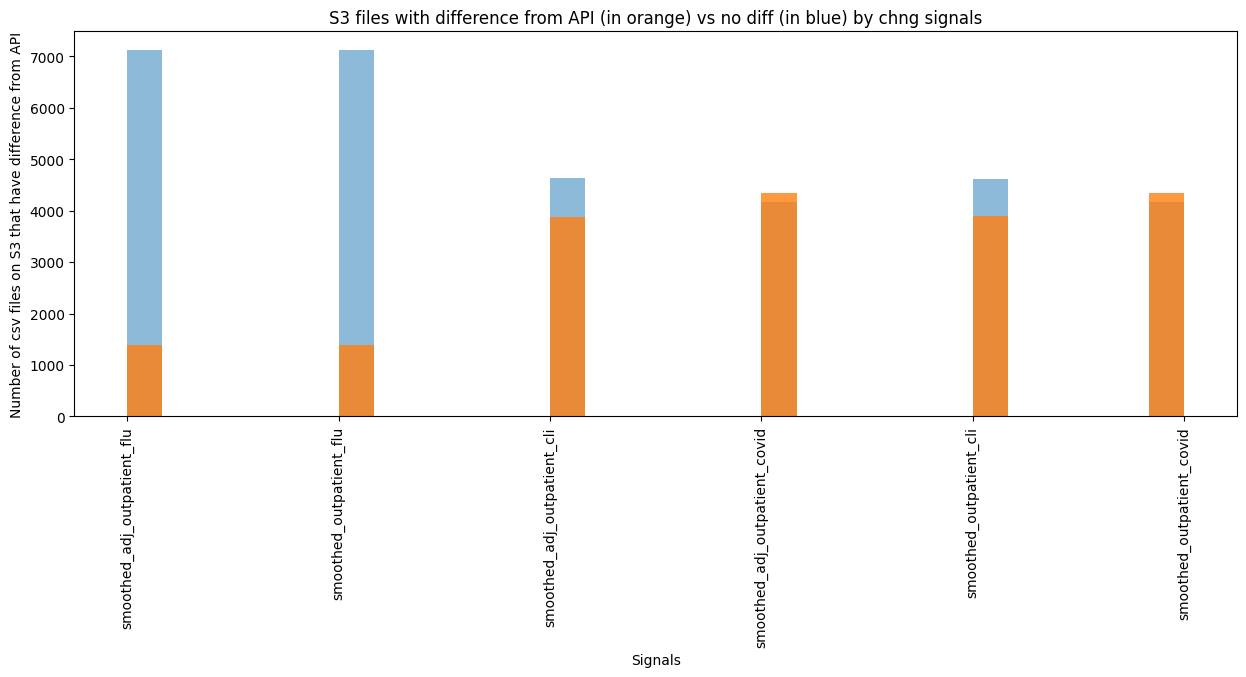

In [196]:
chng_diff = chng[chng['dif_row_count']!=0]
chng_match = chng[chng['dif_row_count']==0]

plt.figure(figsize=(15, 5))
plt.hist(chng_match['signal'], bins=30,alpha=0.5)
plt.hist(chng_diff['signal'], bins=30,alpha=0.8)

# Set the labels and title
plt.xlabel('Signals')
plt.ylabel('Number of csv files on S3 that have difference from API')
plt.title('S3 files with difference from API (in orange) vs no diff (in blue) by chng signals')
plt.xticks(rotation=90)
# Display the plot
plt.show()

/var/folders/gk/ld02_6n171z4tz6ddznd2crc0000gn/T/ipykernel_8971/499176415.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chng_diff['time_value'] = pd.to_datetime(chng_diff['time_value'], format='%Y%m%d')
/var/folders/gk/ld02_6n171z4tz6ddznd2crc0000gn/T/ipykernel_8971/499176415.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chng['time_value'] = pd.to_datetime(chng['time_value'], format='%Y%m%d')


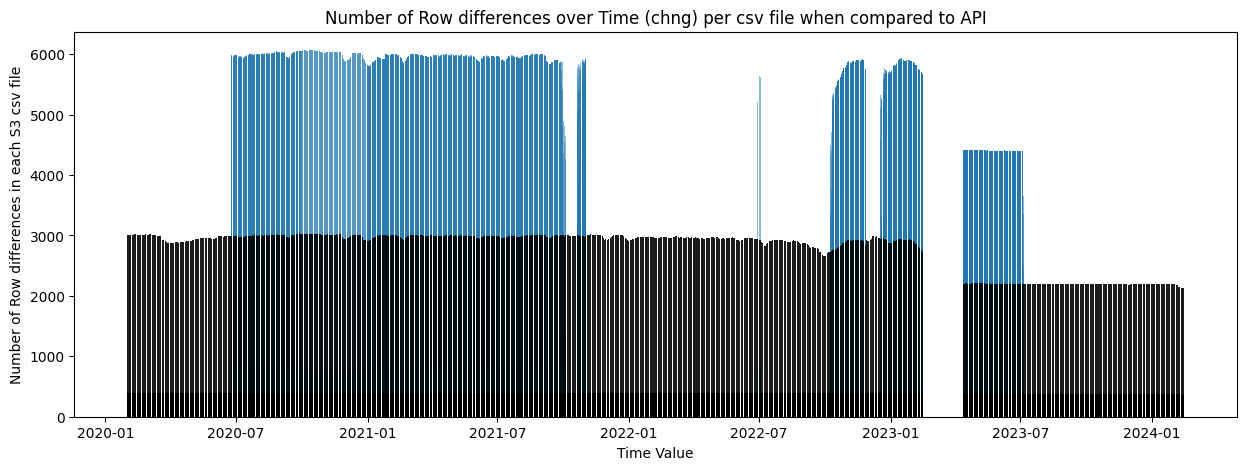

In [197]:
# Convert 'time_value' to datetime
chng_diff['time_value'] = pd.to_datetime(chng_diff['time_value'], format='%Y%m%d')
chng['time_value'] = pd.to_datetime(chng['time_value'], format='%Y%m%d')

# Create a plot
plt.figure(figsize=(15, 5))
plt.bar(chng_diff['time_value'], chng_diff['dif_row_count'], alpha=0.5)
plt.bar(chng['time_value'], chng['s3_row_count'], alpha=0.3, color='black')

# Set the labels and title
plt.xlabel('Time Value')
plt.ylabel('Number of Row differences in each S3 csv file')
plt.title('Number of Row differences over Time (chng) per csv file when compared to API')

# Display the plot
plt.show()

#### 4.hhs
Vast majority of files for this indicator match api (98%).
Late 2023 is when we see a spike of mismatch, right before the indicator got retired.


In [198]:
hhs= df[df["source"]=="hhs"]
# hhs.head(10)

In [199]:
print(len(hhs[hhs['dif_row_count']!=0]))
print(len(hhs))
print(len(hhs[hhs['dif_row_count']!=0])/len(hhs))

818
56736
0.01441765369430344


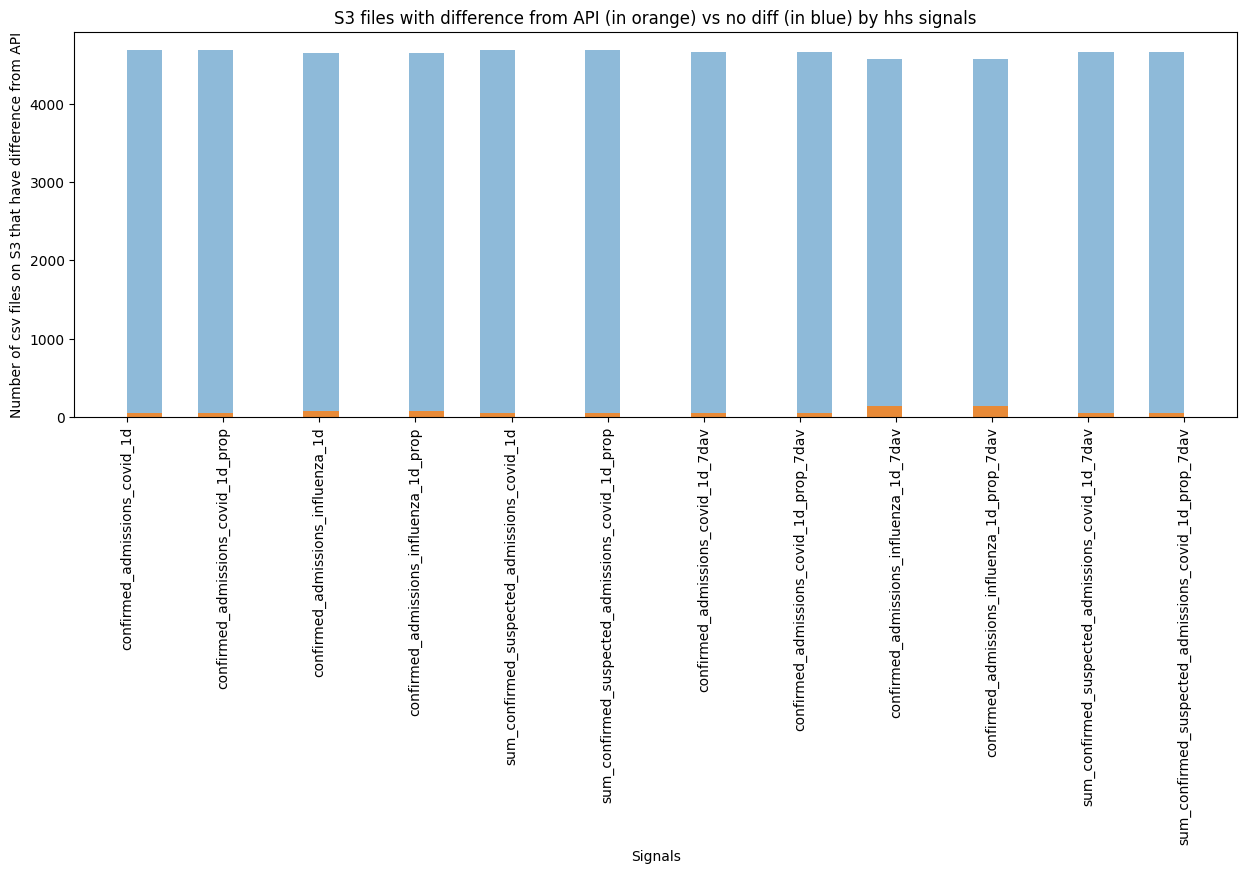

In [200]:
hhs_diff = hhs[hhs['dif_row_count']!=0]
hhs_match = hhs[hhs['dif_row_count']==0]

plt.figure(figsize=(15, 5))
plt.hist(hhs_match['signal'], bins=30, alpha=0.5)
plt.hist(hhs_diff['signal'], bins=30, alpha=0.8)

# Set the labels and title
plt.xlabel('Signals')
plt.ylabel('Number of csv files on S3 that have difference from API')
plt.title('S3 files with difference from API (in orange) vs no diff (in blue) by hhs signals')

plt.xticks(rotation=90)
# Display the plot
plt.show()

/var/folders/gk/ld02_6n171z4tz6ddznd2crc0000gn/T/ipykernel_8971/1682873475.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hhs_diff['time_value'] = pd.to_datetime(hhs_diff['time_value'], format='%Y%m%d')


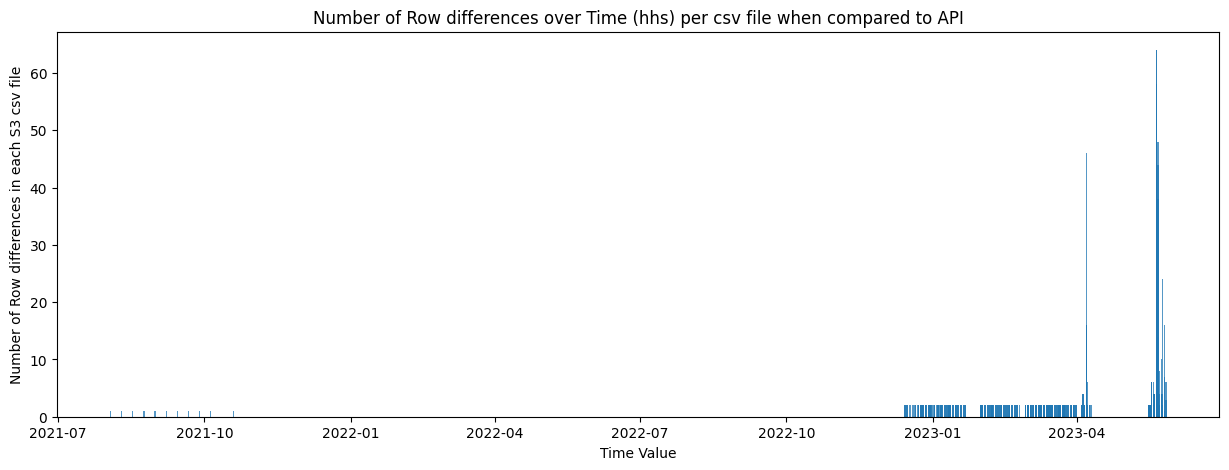

In [201]:
# Convert 'time_value' to datetime
hhs_diff['time_value'] = pd.to_datetime(hhs_diff['time_value'], format='%Y%m%d')

# Create a plot
plt.figure(figsize=(15, 5))
plt.bar(hhs_diff['time_value'], hhs_diff['dif_row_count'], alpha=0.5)

# Set the labels and title
plt.xlabel('Time Value')
plt.ylabel('Number of Row differences in each S3 csv file')
plt.title('Number of Row differences over Time (hhs) per csv file when compared to API')


# Display the plot
plt.show()

#### 5. dsew
About 80% of files all match. 
Among the files with mismatches, most are `confirmed_admissions_covid_1d_7dav` and `confirmed_admissions_covid_1d_7dav_prop`.
Most mismatches are throughout 2021 to early 2022.

In [202]:
dsew = df[df["source"]=="dsew-cpr"]
#dsew.head(10)

In [203]:
print(len(dsew[dsew['dif_row_count']!=0]))
print(len(dsew))
print(len(dsew[dsew['dif_row_count']!=0])/len(dsew))

2691
15651
0.17193789534215065


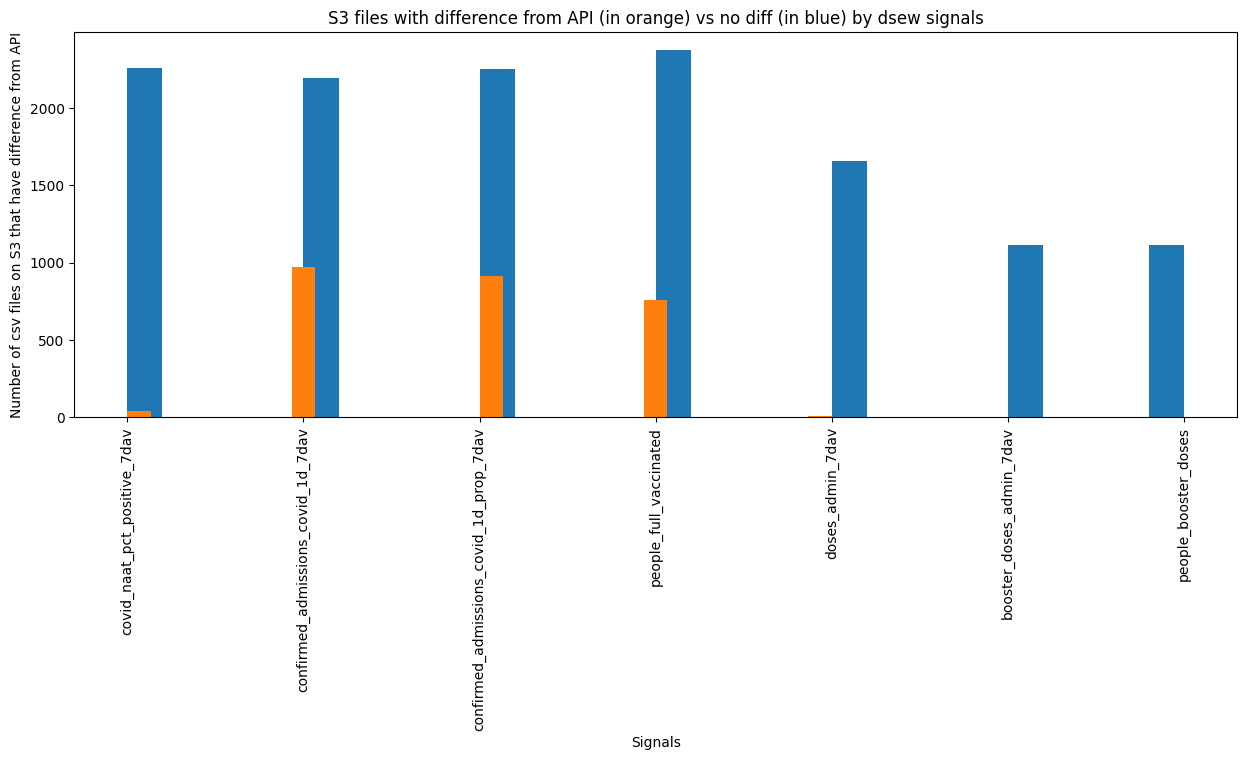

In [204]:
dsew_diff = dsew[dsew['dif_row_count']!=0]
dsew_match = dsew[dsew['dif_row_count']==0]

plt.figure(figsize=(15, 5))
plt.hist(dsew_match['signal'], bins=30, linestyle=':')
plt.hist(dsew_diff['signal'], bins=30,)

# Set the labels and title
plt.xlabel('Signals')
plt.ylabel('Number of csv files on S3 that have difference from API')
plt.title('S3 files with difference from API (in orange) vs no diff (in blue) by dsew signals')
plt.xticks(rotation=90)
# Display the plot
plt.show()

/var/folders/gk/ld02_6n171z4tz6ddznd2crc0000gn/T/ipykernel_8971/2671474670.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dsew_diff['time_value'] = pd.to_datetime(dsew_diff['time_value'], format='%Y%m%d')


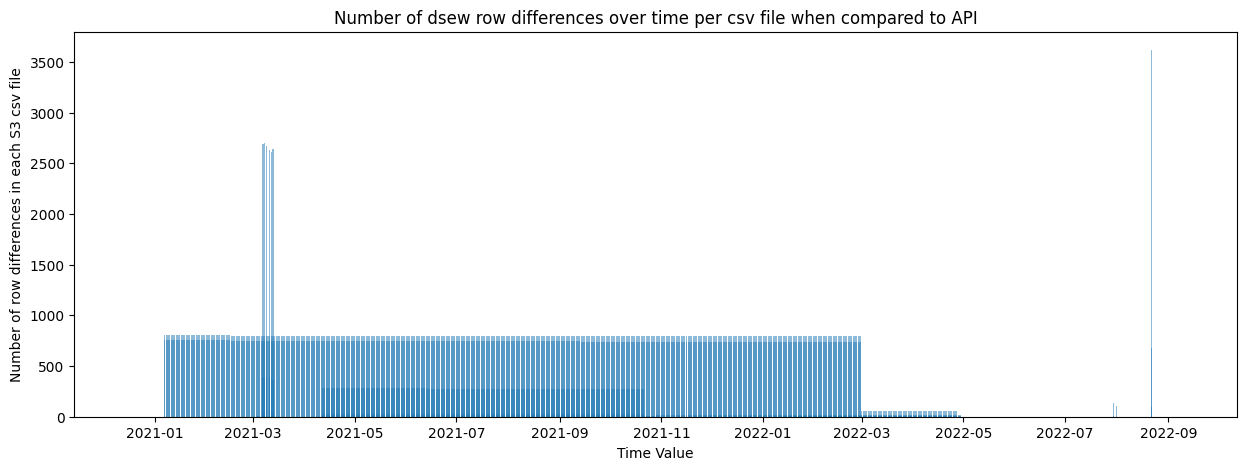

In [205]:
# Convert 'time_value' to datetime
dsew_diff['time_value'] = pd.to_datetime(dsew_diff['time_value'], format='%Y%m%d')

# Create a plot
plt.figure(figsize=(15, 5))
plt.bar(dsew_diff['time_value'], dsew_diff['dif_row_count'], alpha=0.5)

# Set the labels and title
plt.xlabel('Time Value')
plt.ylabel('Number of row differences in each S3 csv file')
plt.title('Number of dsew row differences over time per csv file when compared to API')


# Display the plot
plt.show()

#### 6. usafacts
Around 10% of files are problematic.
Big spike for super brief periods of time in 2020.

In [206]:
usafacts = df[df["source"]=="usa-facts"]
usafacts.head()

,file_name,source,signal,time_value,geo_type,dif_row_count,s3_row_count,api_row_count,full_dif,skip,reason,diff_rate
107420,usafacts/20200122_county_confirmed_cumulative_...,usa-facts,confirmed_cumulative_num,20200122,county,3192.0,3192.0,0.0,1.0,False,NaN,1.0
107421,usafacts/20200122_county_confirmed_cumulative_...,usa-facts,confirmed_cumulative_prop,20200122,county,3142.0,3142.0,0.0,1.0,False,NaN,1.0
107422,usafacts/20200122_county_confirmed_incidence_n...,usa-facts,confirmed_incidence_num,20200122,county,3192.0,3192.0,0.0,1.0,False,NaN,1.0
107423,usafacts/20200122_county_confirmed_incidence_p...,usa-facts,confirmed_incidence_prop,20200122,county,3142.0,3142.0,0.0,1.0,False,NaN,1.0
107424,usafacts/20200122_county_deaths_cumulative_num...,usa-facts,deaths_cumulative_num,20200122,county,3192.0,3192.0,0.0,1.0,False,NaN,1.0


In [207]:
print(len(usafacts[usafacts['dif_row_count']!=0]))
print(len(usafacts))
print(len(usafacts[usafacts['dif_row_count']!=0])/len(usafacts))

9413
90392
0.10413532170988583


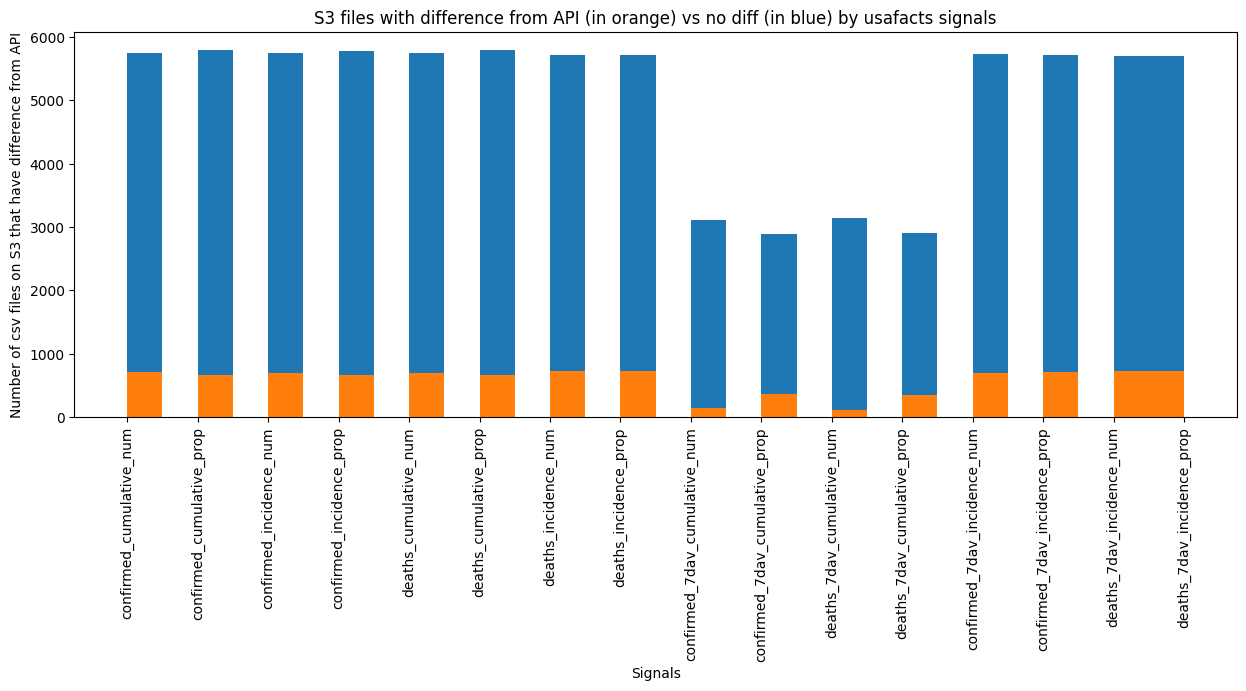

In [208]:
usafacts_diff = usafacts[usafacts['dif_row_count']!=0]
usafacts_match = usafacts[usafacts['dif_row_count']==0]

plt.figure(figsize=(15, 5))
plt.hist(usafacts_match['signal'], bins=30, linestyle=':')
plt.hist(usafacts_diff['signal'], bins=30,)

# Set the labels and title
plt.xlabel('Signals')
plt.ylabel('Number of csv files on S3 that have difference from API')
plt.title('S3 files with difference from API (in orange) vs no diff (in blue) by usafacts signals')
plt.xticks(rotation=90)
# Display the plot
plt.show()

/var/folders/gk/ld02_6n171z4tz6ddznd2crc0000gn/T/ipykernel_8971/822720485.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usafacts_diff['time_value'] = pd.to_datetime(usafacts_diff['time_value'], format='%Y%m%d')


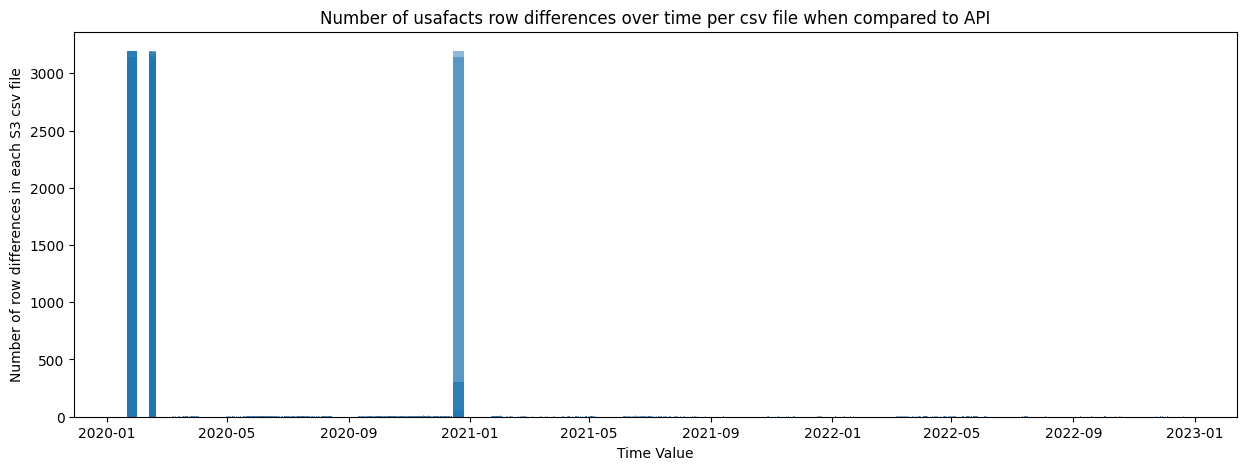

In [209]:
# Convert 'time_value' to datetime
usafacts_diff['time_value'] = pd.to_datetime(usafacts_diff['time_value'], format='%Y%m%d')
# usafacts['time_value'] = pd.to_datetime(usafacts['time_value'], format='%Y%m%d')

# Create a plot
plt.figure(figsize=(15, 5))
plt.bar(usafacts_diff['time_value'], usafacts_diff['dif_row_count'], alpha=0.5)
# plt.bar(usafacts['time_value'], usafacts['s3_row_count'], alpha=0.3, color='black')

# Set the labels and title
plt.xlabel('Time Value')
plt.ylabel('Number of row differences in each S3 csv file')
plt.title('Number of usafacts row differences over time per csv file when compared to API')


# Display the plot
plt.show()